In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import codecs
import json
import os
import pickle
import re
import sys
import time
import traceback

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from glob import glob
from os.path import splitext, split, join, exists
from tqdm import tqdm
from IPython import display

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import joblib
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials,anneal

In [2]:
import xlsxwriter
import toad
import seaborn as sns
from catboost import Pool

In [3]:
from model_tools.gentools import gentools as gntls
from model_tools.gentools import advtools as advtls
from model_tools.plot import feature_plot as fplt
from model_tools.feature_select import feature_select as fs
from model_tools.feature_proc import feature_proc as fp
from model_tools.model import model as mdl

### 数据准备

In [4]:
target = 'target'
dpath = 'E:/git/test_data/'
cfg_path = 'E:/git/model_tools/notebook_demo/'
report_save_path = 'E:/git/model_tools/notebook_demo/model_report/'

exclude_cols = ['OBJECTNO',
 'target',
 'PUTOUTSERIALNO',
 'CUSTOMERID',
 'order_create_time',
 'order_create_at',
 'SERIALNO',
 'NATURALOCCURDATE',
 'APPLSERIALNO',
 'ruleSERIALNO',
 'LK_MOBILENO',
 'RULESERIALNO',
 'JIAOYIRULE_SERIALNO',
 'ref_time']

In [5]:
x_train = pd.read_pickle(join(dpath, 'x_train_with_score.pkl'))
x_test = pd.read_pickle(join(dpath, 'x_test_with_score.pkl'))
oot = pd.read_pickle(join(dpath, 'oot_with_score.pkl'))
print(x_train.shape,x_test.shape,oot.shape)
print(x_train[target].mean(),x_test[target].mean(),oot[target].mean())
x_train.head(2)

(70224, 834) (30096, 834) (34251, 834)
0.059139325586694005 0.05911084529505582 0.053166330910046425


,ely_gt1_repay_amt_rf_repay_max_p7d,ovd_days_rf_due_max_freq_p7d,normal_days_rf_repay_median_p7d,repay_amt_in_table_rf_repay_max_p96d,normal_repay_amt_rf_repay_sum_p96d,ovd_days_rf_due_last_p36d,normal_repay_rto_p8repayment,LK_CUSTOMERLEVEL,normal_days_rf_repay_max_p36d,JY_CREDITMODE,...,级别_GLMMEncoder_afwoe,级别_WOEEncoder_afwoe,级别_LeaveOneOutEncoder_afwoe,级别_CatBoostEncoder_afwoe,pred_lr,pred_xgb,pred_lgb1,pred_lgb2,pred_ctb1,pred_ctb2
0,NaN,0.0,NaN,3261.81,7905.13,0.0,1.0,D1,5.0,NaN,...,-0.053935,-0.053935,-0.053935,-0.053935,0.036338,0.036578,0.020068,0.018431,0.029811,0.028772
1,0.0,0.0,0.0,3006.23,3006.23,0.0,1.0,D1,0.0,NaN,...,-0.053935,-0.053935,-0.053935,-0.053935,0.044539,0.073181,0.054595,0.050812,0.066744,0.068246


In [6]:
with open(join(cfg_path,'cfg','cwoe_cfg'),'r') as load_f:
    cwoe_cfg = json.load(load_f)
with open(join(cfg_path,'cfg','nwoe_cfg'),'r') as load_f:
    nwoe_cfg = json.load(load_f)

In [7]:
model_lr = joblib.load(join(cfg_path,'model','lr.pkl'))
model_xgb = joblib.load(join(cfg_path,'model','xgboost.pkl'))
model_lgb = joblib.load(join(cfg_path,'model','lightgbm1.pkl'))
model_cab = joblib.load(join(cfg_path,'model','catboost1.pkl'))

In [8]:
file_name = '模型报告'
workbook = xlsxwriter.Workbook(join(report_save_path,f'{file_name}.xlsx'))

### 总览

In [9]:
sheet_name = '汇总'
workbook, worksheet = advtls.ExcelWrite().get_workbook_sheet(workbook, work_sheet_name=sheet_name)

In [10]:
######################
# 场景说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='场景说明', 
                                             insert_space='A1', style= {'size':15, 'fg_color':'#00868B', 'bold':True})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='1. 使用场景： 用于评估申请借去花渠道老客的信用风险', 
                                         insert_space='A3', style= {'size':12, 'border': 0}, is_set_col=False)
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='2. 老客定义： 用户申请时间>首次账单日', 
                                         insert_space='A4', style= {'size':12, 'border': 0}, is_set_col=False)


######################
# 样本说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='样本说明', 
                                         insert_space='A6', style= {'size':15, 'fg_color':'#00868B', 'bold':True})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='''1. target说明： 坏用户：用户前3期最大逾期天数>30天; 好用户：用户前3期最大逾期天数<=30天''', 
                                         insert_space='A8', style= {'size':12, 'border': 0}, is_set_col=False)
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value=f'''2. 数据集说明： 使用申请时间在{x_train['NATURALOCCURDATE'].min()}
—{oot['NATURALOCCURDATE'].max()}有3期30+表现的订单建模''', 
                                         insert_space='A9', style= {'size':12, 'border': 0}, is_set_col=False)

for i, (df_name, df) in enumerate({'训练集': x_train, '测试集': x_test, 'oot':oot}.items()):

    workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                             value=f'''    {df_name}： 申请时间：{df['NATURALOCCURDATE'].min()}—{df['NATURALOCCURDATE'].max()}，
样本量：{df.shape[0]}，坏用户占比{round(df[target].mean(),4)*100}%''', 
                                             insert_space='A'+f'{10+i}', style= {'size':11, 'border': 0}, is_set_col=False)

######################
# 特征说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='特征说明', 
                                         insert_space='A14', style= {'size':15, 'fg_color':'#00868B', 'bold':True})
st = pd.DataFrame({'渠道':['百融','百融','百融','同盾','同盾','行内'],
              '特征中文名':['xx1','xx2','xx3','xx4','xx5','xx6'],
              '特征英文名':['hh1','hh2','hh3','hh4','hh5','hh6']})
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A16', style={})


######################
# 效果说明
######################
start_col = 16+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='模型效果说明', 
                                         insert_space='A'+str(start_col), style= {'size':15, 'fg_color':'#00868B', 'bold':True})

ks_list, auc_list = [],[]
for model in [model_lr, model_xgb, model_lgb, model_cab]:
    for df in [x_train,x_test,oot]:
        ks_,auc_,_ = mdl.evaluate_performance(df[target], mdl.ModelApply.model_predict(df[mdl.get_feature_names(model)],
                                                                       model), to_plot=False)
        ks_list.append(ks_)
        auc_list.append(auc_)
st = pd.DataFrame({'模型':['逻辑回归模型']*3+['xgboost模型']*3+['lightgbm模型']*3+['catboost模型']*3,
                   '数据集':['训练集','测试集','oot']*4,'ks':ks_list,'auc':auc_list})

start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})

### 样本说明

In [11]:
sheet_name = '样本说明'
workbook, worksheet = advtls.ExcelWrite().get_workbook_sheet(workbook, work_sheet_name=sheet_name)

In [12]:
######################
# 样本说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='样本说明', 
                                             insert_space='A1', style= {'size':15, 'fg_color':'#00868B', 'bold':True})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='按月查看用户逾期情况：', 
                                         insert_space='A3', style= {'size':12, 'border': 0}, is_set_col=False)

df = pd.concat([x_train[['OBJECTNO','NATURALOCCURDATE']+[target]],
                x_test[['OBJECTNO','NATURALOCCURDATE']+[target]],
                oot[['OBJECTNO','NATURALOCCURDATE']+[target]]],axis=0).reset_index(drop=True)
df['month'] = df['NATURALOCCURDATE'].apply(lambda x: x[:7])
st = df.groupby('month').agg({target:['count',sum,'mean']})
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A5', style={})


######################
# 数据集切分
######################
start_col = 6+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='数据集切分', 
                                             insert_space='A'+str(start_col), style= {'size':15, 'fg_color':'#00868B', 'bold':True})

start_col = start_col+2
sample = {'训练集': '随机采样70%', '测试集': '随机采样30%', 'oot': '全量数据'}
for df_name, df in {'训练集': x_train, '测试集': x_test, 'oot':oot}.items():
    workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                             value=f''' {df_name}： 申请时间：{df['NATURALOCCURDATE'].min()}—{df['NATURALOCCURDATE'].max()}，{sample[df_name]}，
样本量：{df.shape[0]}，坏用户占比{round(df[target].mean(),4)*100}%''', 
                                             insert_space='A'+str(start_col), style= {'size':11, 'border': 0}, is_set_col=False)

    start_col = start_col+1
    title = f'{df_name}_NATURALOCCURDATE'
    pic = fplt.PlotUtils().plot_bivar(df, feas='NATURALOCCURDATE', target=target, cut_params=None, title=title,
                    yaxis='count', pyecharts=False, mark_line=True,
                    draw_lin=False, save_path=join(report_save_path, 'report_pic'), 
                    color_bar=['steelblue'], color_line=['red','black'])
    workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic',f'{title}.png'), insert_space='A'+str(start_col))
                          
    start_col = start_col+25                 


### 逻辑回归模型说明

In [13]:
sheet_name = '逻辑回归模型'
workbook, worksheet = advtls.ExcelWrite().get_workbook_sheet(workbook, work_sheet_name=sheet_name)

In [14]:
model = model_lr
feas = mdl.get_feature_names(model)

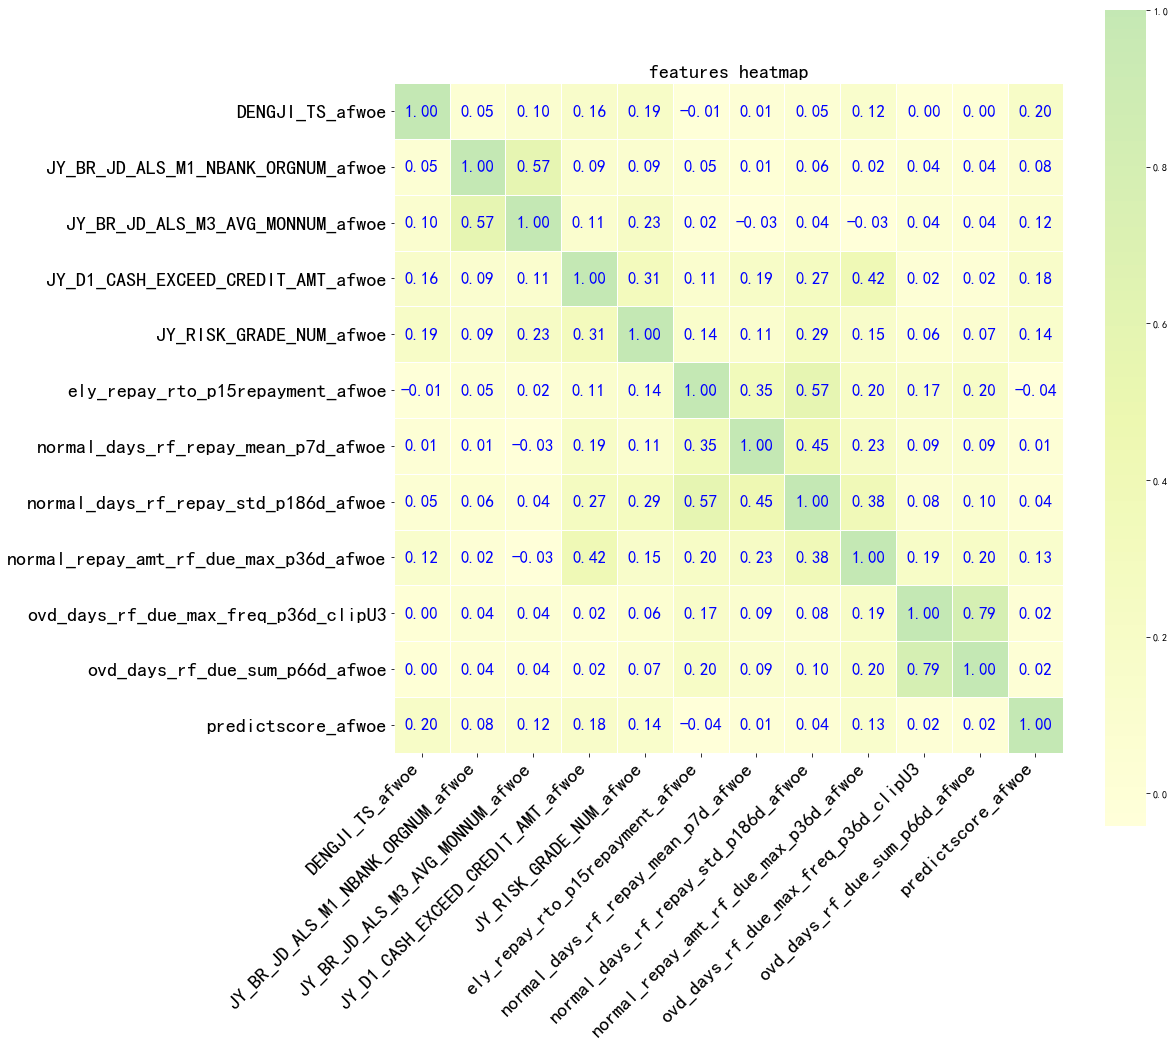

In [15]:
######################
# 特征说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='入模特征', 
                                             insert_space='A1', style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='1. 特征说明：', 
                                         insert_space='A3', style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
st = pd.DataFrame({'特征英文名': feas})
st['特征中文名'] = [gntls.get_random_object(count=42, dtype=str)]*len(feas)
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A5', style={})


######################
# 特征概览
######################
start_col = 6+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='2. 特征概览：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_detect = toad.detector.detect(x_train[feas]).reset_index().rename(columns={'index':'features'})
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_detect, insert_space='A'+str(start_col), style={})


######################
# 特征相关性
######################
start_col = start_col+feas_detect.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='3. 特征相关性：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
st = x_train[mdl.get_feature_names(model)].corr().reset_index().rename(columns={'index':'features'})
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})

f, ax = plt.subplots(figsize=(15, 15))
pic = sns.heatmap(x_train[feas].corr(),
            square=True, fmt='.2f', annot_kws={'size':17,'weight':'bold', 'color':'blue'},
            linewidths=1, cmap='YlGnBu',center=2, annot=True, ax=ax)
_ = plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
_ = plt.setp(ax.get_yticklabels(), fontsize=20)
plt.title("features heatmap", fontsize=20)
fig = pic.get_figure()
fig.savefig(join(report_save_path,'report_pic','heatmap.png'), bbox_inches='tight')

start_col = start_col+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic','heatmap.png'), insert_space='A'+str(start_col))
start_col = start_col+36


######################
# 特征效果
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='4. 特征效果：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
start_col = start_col+2
for fea in feas:
    pat = 'TS|selfcut|TargetEncoder|MEstimateEncoder|JamesSteinEncoder|GLMMEncoder|WOEEncoder|LeaveOneOutEncoder|CatBoostEncoder'
    if re.search(pat,fea):
        fea_org = re.sub('|'.join([f'_{c}_afwoe' for c in pat.split('|')]),'',fea)
        st = pd.DataFrame(cwoe_cfg[fea], index=[0]).T.rename(columns={0:'woe'}).\
             merge(mdl.get_pred_cutoff(x_train, fea_org, target, cut_params=None, ispred=False)[0], 
             left_index=True, right_index=True)
        st = st.reset_index().rename(columns={'index':fea_org})
    elif re.search('_afwoe',fea):
        fea_org = fea[:-6]
        st = pd.DataFrame(nwoe_cfg[fea_org]['woe_cfg'], index=[0]).T.reset_index().rename(columns={'index':fea_org ,0:'woe'}).\
             merge(mdl.get_pred_cutoff(x_train, fea, target, cut_params=None, ispred=False)[0].\
             reset_index().rename(columns={fea:'woe'}), on='woe')
    else:
        fea_org = fea
        st = mdl.get_pred_cutoff(x_train, fea_org, target, cut_params=None, ispred=False)[0].reset_index()
        
    pic = fplt.PlotUtils().plt_plot_twinx(st.set_index(fea_org), cols_name=['总样本数'], target=['坏样本占比'], 
                                        title=f'{fea_org}_performance',
                                        color_bar=['steelblue'], color_line=['red'], scale_num=20, 
                                        save_path=join(report_save_path,'report_pic'))

    workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})
    start_col = start_col+st.shape[0]+2
    workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic',f'{fea_org}_performance.png'), insert_space='A'+str(start_col))
    start_col = start_col+28


######################
# 特征重要性
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='5. 特征重要性：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_imp = pd.DataFrame([(v[0], float(v[1]), float(v[3]), float(v[4]))
                                 for v in model.summary().tables[1].data[1:-1]],
                                columns=['feature', 'coef', 'zscore', 'pval'])
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_imp, insert_space='A'+str(start_col), style={})
start_col = start_col+feas_imp.shape[0]+5

In [16]:
score_name = 'pred_lr'

In [17]:
######################
# 模型效果
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='模型效果', 
                                             insert_space='A'+str(start_col), style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
start_col = start_col+2


bins = advtls.cut_feas(x_train, score_name, target, cut_params=10)
for v in ['x_train','x_test','oot']:
    _, _, pic, inform = mdl.evaluate_performance(eval(v)[target], mdl.ModelApply.model_predict(eval(v)[feas], model),
                                            suptitle=f'{v}_lr_model_performance', bins=10, save_path=join(report_save_path,'report_pic'))
    workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value=f'{v}_效果', 
                                         insert_space='A'+str(start_col), style= {'size':11, 'border': 0, 'bold':True}, is_set_col=False)
    start_col = start_col+1
    
    for value in inform:
        start_col = start_col+1
        workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                             value=value, 
                                             insert_space='A'+str(start_col), style= {'size':10, 'border': 0, 'bold':False}, is_set_col=False)
    start_col = start_col+2
    st = mdl.get_pred_cutoff(eval(v), score_name, target, cut_params=bins, ispred=False)[0].reset_index()
    workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})
    start_col = start_col+st.shape[0]+2
    
    workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic',f'{v}_lr_model_performance.png'), insert_space='A'+str(start_col))
    
    start_col = start_col+38

### xgboost模型说明

In [18]:
sheet_name = 'xgboost模型'
workbook, worksheet = advtls.ExcelWrite().get_workbook_sheet(workbook, work_sheet_name=sheet_name)

In [19]:
model = model_xgb
feas = mdl.get_feature_names(model)

In [20]:
######################
# 特征说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='入模特征', 
                                             insert_space='A1', style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='1. 特征说明：', 
                                         insert_space='A3', style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
st = pd.DataFrame({'特征英文名': feas})
st['特征中文名'] = [gntls.get_random_object(count=42, dtype=str)]*len(feas)
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A5', style={})


######################
# 特征概览
######################
start_col = 6+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='2. 特征概览：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_detect = toad.detector.detect(x_train[feas]).reset_index().rename(columns={'index':'features'})
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_detect, insert_space='A'+str(start_col), style={})


######################
# 特征重要性
######################
start_col = start_col+feas_detect.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='3. 特征重要性：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_imp = mdl.ModelImportance.tree_importance(model).merge(mdl.ModelImportance.tree_shap_importance(model,x_train[feas]),
            left_index=True, right_index=True).reset_index()
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_imp, insert_space='A'+str(start_col), style={})
start_col = start_col+feas_imp.shape[0]+2

fplt.PlotUtils().plt_plot(feas_imp.sort_values('shap_importance').set_index('features'), 
                          cols_name=['shap_importance'], plot_type='barh', title='feas importance',
                          color_list=['steelblue','darkseagreen','tan','rosybrown','cadetblue','cadetblue'], 
                          scale_num=40, save_path=join(report_save_path,'report_pic'))

workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic','feas importance.png'), insert_space='A'+str(start_col))

start_col = start_col+26


In [21]:
score_name = 'pred_xgb'

In [22]:
######################
# 模型效果
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='模型效果', 
                                             insert_space='A'+str(start_col), style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
start_col = start_col+2


bins = advtls.cut_feas(x_train, score_name, target, cut_params=10)
for v in ['x_train','x_test','oot']:
    _, _, pic, inform = mdl.evaluate_performance(eval(v)[target], mdl.ModelApply.model_predict(eval(v)[feas], model),
                                            suptitle=f'{v}_xgb_model_performance', bins=10, save_path=join(report_save_path,'report_pic'))
    workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value=f'{v}_效果', 
                                         insert_space='A'+str(start_col), style= {'size':11, 'border': 0, 'bold':True}, is_set_col=False)
    start_col = start_col+1
    
    for value in inform:
        start_col = start_col+1
        workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                             value=value, 
                                             insert_space='A'+str(start_col), style= {'size':10, 'border': 0, 'bold':False}, is_set_col=False)
    start_col = start_col+2
    st = mdl.get_pred_cutoff(eval(v), score_name, target, cut_params=bins, ispred=False)[0].reset_index()
    workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})
    start_col = start_col+st.shape[0]+2
    
    workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic',f'{v}_xgb_model_performance.png'), insert_space='A'+str(start_col))
    
    start_col = start_col+38

### lightgbm模型说明

In [23]:
sheet_name = 'lightgbm模型'
workbook, worksheet = advtls.ExcelWrite().get_workbook_sheet(workbook, work_sheet_name=sheet_name)

In [24]:
model = model_lgb
feas = mdl.get_feature_names(model)

In [25]:
######################
# 特征说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='入模特征', 
                                             insert_space='A1', style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='1. 特征说明：', 
                                         insert_space='A3', style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
st = pd.DataFrame({'特征英文名': feas})
st['特征中文名'] = [gntls.get_random_object(count=42, dtype=str)]*len(feas)
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A5', style={})


######################
# 特征概览
######################
start_col = 6+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='2. 特征概览：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_detect = toad.detector.detect(x_train[feas]).reset_index().rename(columns={'index':'features'})
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_detect, insert_space='A'+str(start_col), style={})


######################
# 特征重要性
######################
start_col = start_col+feas_detect.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='3. 特征重要性：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_imp = mdl.ModelImportance.tree_importance(model).merge(mdl.ModelImportance.tree_shap_importance(model,x_train[feas]),
            left_index=True, right_index=True).reset_index()
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_imp, insert_space='A'+str(start_col), style={})
start_col = start_col+feas_imp.shape[0]+2

fplt.PlotUtils().plt_plot(feas_imp.sort_values('shap_importance').set_index('features'), 
                          cols_name=['shap_importance'], plot_type='barh', title='feas importance',
                          color_list=['steelblue','darkseagreen','tan','rosybrown','cadetblue','cadetblue'], 
                          scale_num=40, save_path=join(report_save_path,'report_pic'))

workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic','feas importance.png'), insert_space='A'+str(start_col))

start_col = start_col+26


In [26]:
score_name = 'pred_lgb1'

In [27]:
######################
# 模型效果
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='模型效果', 
                                             insert_space='A'+str(start_col), style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
start_col = start_col+2


bins = advtls.cut_feas(x_train, score_name, target, cut_params=10)
for v in ['x_train','x_test','oot']:
    _, _, pic, inform = mdl.evaluate_performance(eval(v)[target], mdl.ModelApply.model_predict(eval(v)[feas], model),
                                            suptitle=f'{v}_lgb_model_performance', bins=10, save_path=join(report_save_path,'report_pic'))
    workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value=f'{v}_效果', 
                                         insert_space='A'+str(start_col), style= {'size':11, 'border': 0, 'bold':True}, is_set_col=False)
    start_col = start_col+1
    
    for value in inform:
        start_col = start_col+1
        workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                             value=value, 
                                             insert_space='A'+str(start_col), style= {'size':10, 'border': 0, 'bold':False}, is_set_col=False)
    start_col = start_col+2
    st = mdl.get_pred_cutoff(eval(v), score_name, target, cut_params=bins, ispred=False)[0].reset_index()
    workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})
    start_col = start_col+st.shape[0]+2
    
    workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic',f'{v}_lgb_model_performance.png'), insert_space='A'+str(start_col))
    
    start_col = start_col+38

### catboost模型说明

In [28]:
sheet_name = 'catboost模型'
workbook, worksheet = advtls.ExcelWrite().get_workbook_sheet(workbook, work_sheet_name=sheet_name)

In [29]:
model = model_cab
feas = mdl.get_feature_names(model)
cat_feas = x_train[feas].select_dtypes('object').columns.tolist()
dtrain = Pool(data=x_train[feas], label=x_train[target], cat_features=cat_feas)
model.dtrain = dtrain

In [30]:
######################
# 特征说明
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='入模特征', 
                                             insert_space='A1', style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='1. 特征说明：', 
                                         insert_space='A3', style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
st = pd.DataFrame({'特征英文名': feas})
st['特征中文名'] = [gntls.get_random_object(count=42, dtype=str)]*len(feas)
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A5', style={})


######################
# 特征概览
######################
start_col = 6+st.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='2. 特征概览：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_detect = toad.detector.detect(x_train[feas]).reset_index().rename(columns={'index':'features'})
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_detect, insert_space='A'+str(start_col), style={})


######################
# 特征重要性
######################
start_col = start_col+feas_detect.shape[0]+2
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value='3. 特征重要性：', 
                                         insert_space='A'+str(start_col), style= {'size':12, 'border': 0, 'bold':True}, is_set_col=False)
feas_imp = mdl.ModelImportance.tree_importance(model).merge(mdl.ModelImportance.tree_shap_importance(model,x_train[feas]),
            left_index=True, right_index=True).reset_index()
start_col = start_col+2
workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=feas_imp, insert_space='A'+str(start_col), style={})
start_col = start_col+feas_imp.shape[0]+2

fplt.PlotUtils().plt_plot(feas_imp.sort_values('shap_importance').set_index('features'), 
                          cols_name=['shap_importance'], plot_type='barh', title='feas importance',
                          color_list=['steelblue','darkseagreen','tan','rosybrown','cadetblue','cadetblue'], 
                          scale_num=40, save_path=join(report_save_path,'report_pic'))

workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic','feas importance.png'), insert_space='A'+str(start_col))

start_col = start_col+26


In [31]:
score_name = 'pred_ctb1'

In [32]:
######################
# 模型效果
######################
workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, value='模型效果', 
                                             insert_space='A'+str(start_col), style= {'size':15, 'bold':True, 'fg_color':'#00868B'})
start_col = start_col+2


bins = advtls.cut_feas(x_train, score_name, target, cut_params=10)
for v in ['x_train','x_test','oot']:
    _, _, pic, inform = mdl.evaluate_performance(eval(v)[target], mdl.ModelApply.model_predict(eval(v)[feas], model),
                                            suptitle=f'{v}_cab_model_performance', bins=10, save_path=join(report_save_path,'report_pic'))
    workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                         value=f'{v}_效果', 
                                         insert_space='A'+str(start_col), style= {'size':11, 'border': 0, 'bold':True}, is_set_col=False)
    start_col = start_col+1
    
    for value in inform:
        start_col = start_col+1
        workbook, worksheet = advtls.ExcelWrite().insert_value2table(workbook, worksheet, 
                                             value=value, 
                                             insert_space='A'+str(start_col), style= {'size':10, 'border': 0, 'bold':False}, is_set_col=False)
    start_col = start_col+2
    st = mdl.get_pred_cutoff(eval(v), score_name, target, cut_params=bins, ispred=False)[0].reset_index()
    workbook, worksheet = advtls.ExcelWrite().insert_df2table(workbook, worksheet, df=st, insert_space='A'+str(start_col), style={})
    start_col = start_col+st.shape[0]+2
    
    workbook, worksheet = advtls.ExcelWrite().insert_pic2table(workbook, worksheet, 
                          join(report_save_path,'report_pic',f'{v}_cab_model_performance.png'), insert_space='A'+str(start_col))
    
    start_col = start_col+38
    


In [33]:
workbook.close()